# Lesson 7: Adding Prompt & Resource Features

In the previous lessons, you created an MCP server that provides only tools. In this lesson, you are provided with an updated file for the research server file which now provides a prompt template and 2 resources features in addition to the 2 tools. You are also provided with an updated file for the mcp chatbot file where the MCP client exposes the prompt and resources for the user to use. The files are provided in the `mcp_project` folder.

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b> To Access the  <code>mcp_project</code> folder :</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em> and finally 3) click on <em>L7</em>.
</div>

## Defining Resources and Prompts in the MCP Server - Optional Reading

Feel to read this section before or after you watch the video. You can always skip and go to the end of the notebook to run the updated chatbot. 

**Resources**

You learned from lesson 3 that the research server saves the information of the researched papers in a `json` file called `papers_info.json`, which is stored under a folder labeled with the topic name. All the topics are stored under the `papers` directory. If you check the `papers` folder provided to you under `mcp_project`, you will find two folders labeled `ai_interpretability` and `llm_reasoning`, and in each folder, you have `papers_info.json` file. 

Resources are read-only data that an MCP server can expose to the LLM application. Resources are similar to GET endpoints in a REST API - they provide data but shouldn't perform significant computation or have side effects. For example, the resource can be a list of folders within a directory or the content of a file within a folder. Here, the MCP server provides two resources:
- list of available topic folders under the papers directory;
- the papers' information stored under a topic folder.

Here's a code snippet that shows how resources are defined in the MCP server again using `FastMCP` (with the use of the decorator `@mcp.resource(uri)`). You can find the complete code in the `mcp_project` folder. The URI defined inside `@mcp.resource()` is used to uniquely identify the resource and, as a server developer, you can customize the URI. But in general, it follows this scheme:
`sth://xyz/xcv` . In this example, two types of URI were used:
- static URI: `papers://folders` (which represents the list of available topics)
- dynamic URI: `papers://{topic}` (which represents the papers' information under the topic specified by the client during runtime)

``` python
@mcp.resource("papers://folders")
def get_available_folders() -> str:
    """
    List all available topic folders in the papers directory.
    
    This resource provides a simple list of all available topic folders.
    """
    folders = []
    
    # Get all topic directories
    if os.path.exists(PAPER_DIR):
        for topic_dir in os.listdir(PAPER_DIR):
            topic_path = os.path.join(PAPER_DIR, topic_dir)
            if os.path.isdir(topic_path):
                papers_file = os.path.join(topic_path, "papers_info.json")
                if os.path.exists(papers_file):
                    folders.append(topic_dir)
    
    # Create a simple markdown list
    content = "# Available Topics\n\n"
    if folders:
        for folder in folders:
            content += f"- {folder}\n"
        content += f"\nUse @{folder} to access papers in that topic.\n"
    else:
        content += "No topics found.\n"
    
    return content

@mcp.resource("papers://{topic}")
def get_topic_papers(topic: str) -> str:
    """
    Get detailed information about papers on a specific topic.
    
    Args:
        topic: The research topic to retrieve papers for
    """
    topic_dir = topic.lower().replace(" ", "_")
    papers_file = os.path.join(PAPER_DIR, topic_dir, "papers_info.json")
    
    if not os.path.exists(papers_file):
        return f"# No papers found for topic: {topic}\n\nTry searching for papers on this topic first."
    
    try:
        with open(papers_file, 'r') as f:
            papers_data = json.load(f)
        
        # Create markdown content with paper details
        content = f"# Papers on {topic.replace('_', ' ').title()}\n\n"
        content += f"Total papers: {len(papers_data)}\n\n"
        
        for paper_id, paper_info in papers_data.items():
            content += f"## {paper_info['title']}\n"
            content += f"- **Paper ID**: {paper_id}\n"
            content += f"- **Authors**: {', '.join(paper_info['authors'])}\n"
            content += f"- **Published**: {paper_info['published']}\n"
            content += f"- **PDF URL**: [{paper_info['pdf_url']}]({paper_info['pdf_url']})\n\n"
            content += f"### Summary\n{paper_info['summary'][:500]}...\n\n"
            content += "---\n\n"
        
        return content
    except json.JSONDecodeError:
        return f"# Error reading papers data for {topic}\n\nThe papers data file is corrupted."
```

**Prompt Template**

Server can also provide a prompt template. You can define this feature in the MCP server using the decorator `@mcp.prompt()` as shown in the code snippet below. MCP will use `generate_search_prompt` as the prompt name, infer the prompt arguments from the function's argument and the prompt's description from the doc string.

```python
@mcp.prompt()
def generate_search_prompt(topic: str, num_papers: int = 5) -> str:
    """Generate a prompt for Claude to find and discuss academic papers on a specific topic."""
    return f"""Search for {num_papers} academic papers about '{topic}' using the search_papers tool. Follow these instructions:
    1. First, search for papers using search_papers(topic='{topic}', max_results={num_papers})
    2. For each paper found, extract and organize the following information:
       - Paper title
       - Authors
       - Publication date
       - Brief summary of the key findings
       - Main contributions or innovations
       - Methodologies used
       - Relevance to the topic '{topic}'
    
    3. Provide a comprehensive summary that includes:
       - Overview of the current state of research in '{topic}'
       - Common themes and trends across the papers
       - Key research gaps or areas for future investigation
       - Most impactful or influential papers in this area
    
    4. Organize your findings in a clear, structured format with headings and bullet points for easy readability.
    
    Please present both detailed information about each paper and a high-level synthesis of the research landscape in {topic}."""
```

## Using Resources and Prompts in the MCP Chatbot - Optional Reading

The chatbot is updated to enable users to interact with the prompt using the slash command:
- Users can use the command `/prompts` to list the available prompts
- Users can use the command `/prompt <name> <arg1=value1>` to invoke a particular prompt
  
The chatbot also enables users to interact with the resources using the `@` character:
- Users can use the command `@folders` to see available topics
- Users can use the command `@topic` to get papers info under that topic

Make sure to check the updated code in the `mcp_project` folder. There's a couple of newly added methods (`get_resource`, `execute_prompt`, `list_prompts`). Here's a brief summary of the updates added to the chatbot:

- In `connect_to_server`: the client requests from the server to list the resources and prompt templates they provide (in addition to the tools request). The resource URIs and the prompt names are stored in the MCP chatbot.
   
    <img src="images/resource_discovery.png" width="400">


    <img src="images/prompt_discovery.png" width="400">


- In `chat_loop`: the user's input is checked to see if the user has used any of the slash commands or @ options.

- If the user types: `@folders` or `@topic` then the newly added method `get_resource` is called where the request is sent to the server.
   
    <img src="images/resource_invocation.png" width="400">

- If the user types: `/prompts`, then the newly added method `list_prompts` is called.
   
- If the user types: `/prompt <name> <arg1=value1>`, then the newly added method `execute_prompt` is called where the request is sent to the server:
   
   <img src="images/prompt_invocation.png" width="400">
   
   and the prompt is passed to the LLM. 
- Otherwise the query is processed by the LLM.

## Running the MCP Chatbot

**Terminal Instructions**

- To open the terminal, run the cell below.
- Open the terminal below.
- Navigate to the `mcp_project` directory:
    - `cd L7/mcp_project`
- Activate the virtual environment:
    - `source .venv/bin/activate`
- Run the chatbot:
    - `uv run mcp_chatbot.py`
- To exit the chatbot, type `quit`.
- If you run some queries and would like to access the `papers` folder or any output files: 1) click on the `File` option on the top menu of the notebook and 2) click on `Open` and then 3) click on `L7` -> `mcp_project`.

In [1]:
# start a new terminal
import os
from IPython.display import IFrame

IFrame(
    f"{os.environ.get('DLAI_LOCAL_URL').format(port=8888)}terminals/4",
    width=600,
    height=768,
)

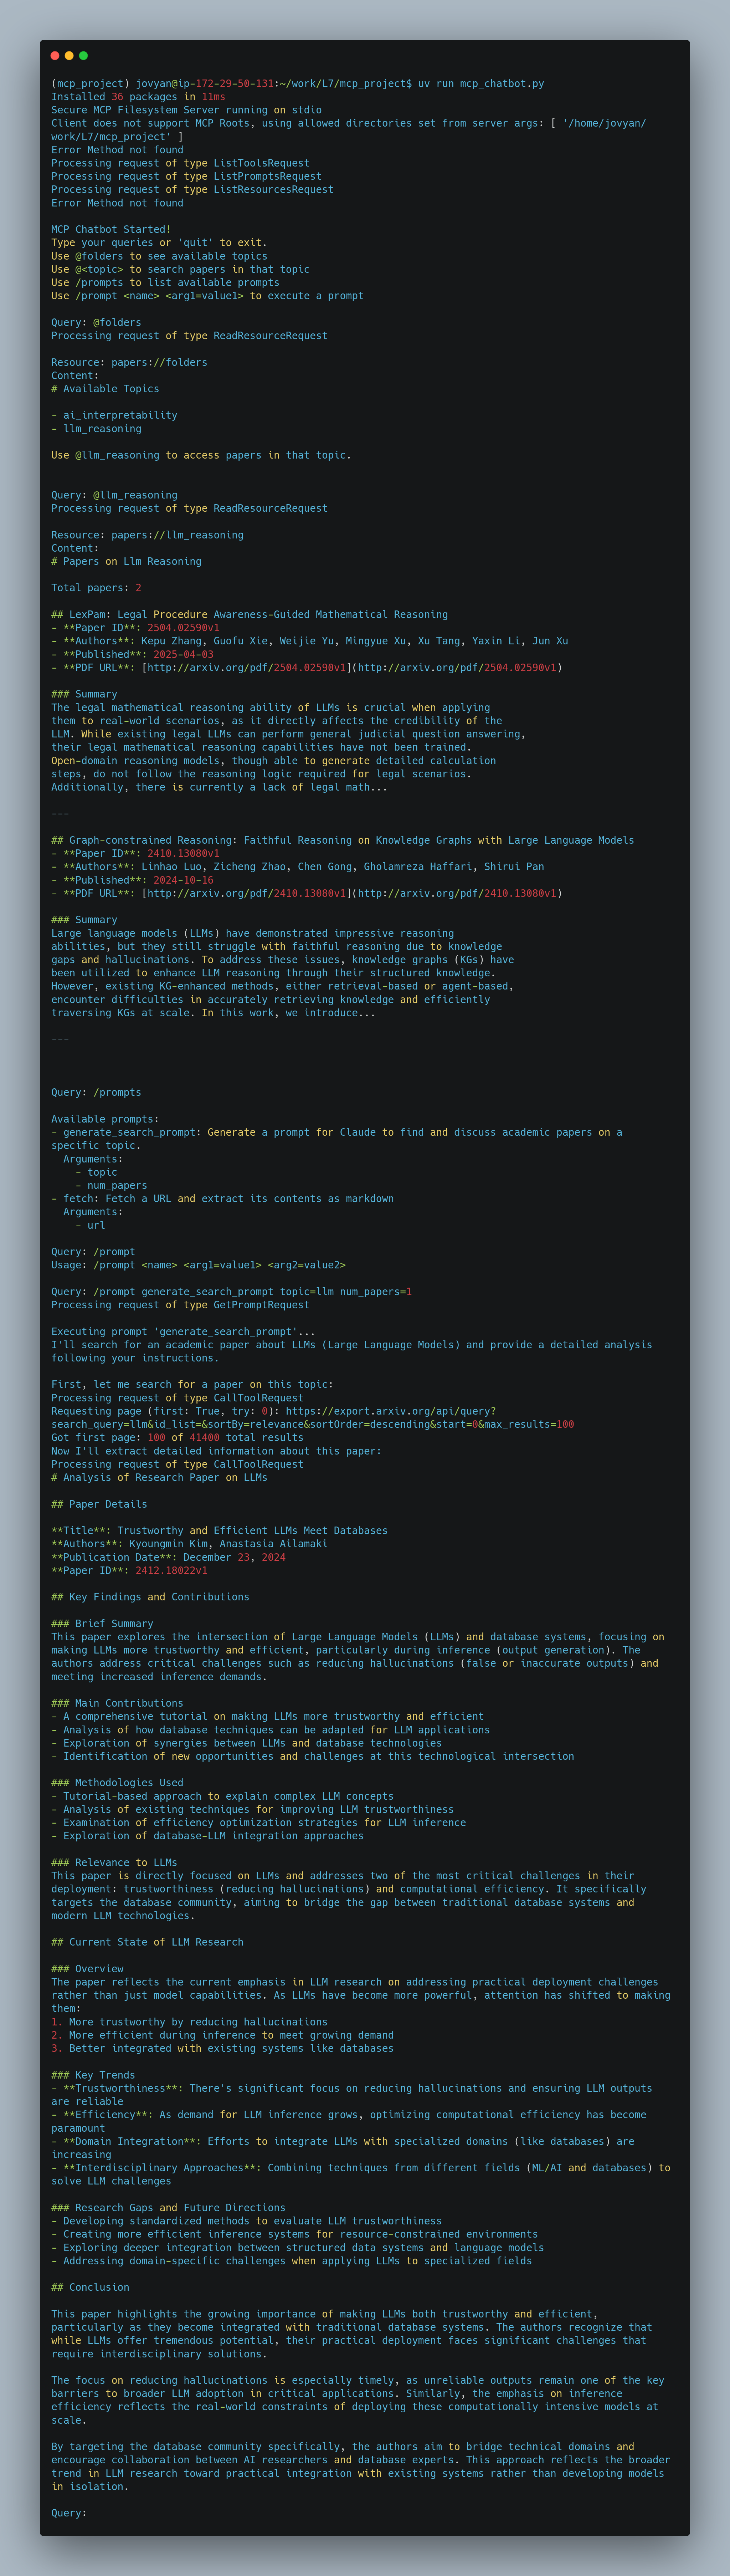

Make sure to interact with the chatbot. Here are some query examples:
- **@folders**
- **@ai_interpretability**
- **/prompts**
- **/prompt generate_search_prompt topic=history num_papers=2**

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> ⬇ &nbsp; <b>To Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>